In [1]:
import yfinance as yf
import datetime as dt
import pandas_datareader as pdr
import pandas as pd
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\FileBase")

from root_functions import add_indicators, up_down, full_prediction, full_prediction_binary, result

## Descarga datos y creación dataset

In [3]:
sample_per = 400
stock = 'EURGBP=X'

end = dt.date.today()- dt.timedelta(days=2)
start = end - dt.timedelta(days=(sample_per))
interval = '1h'

In [4]:
database = yf.download(stock, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [5]:
#Añadimos indicadores

ema1=200
ema2=50
ema3=20

data_base = add_indicators(database)

#Añadimos columna up_down
data_base = up_down(data_base)

#Listado indicadores
data_base.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'log_ret', 'Up_Down'],
      dtype='object')

In [6]:
#Hacemos un shift a la columna Up_Down para tener el signo de la tendencia de la siguiente vela
data_base['Up_Down'] = data_base['Up_Down'].shift(-1)

data_base.dropna(inplace=True)

In [7]:
#Filtramos las columnas que nos interesan para obtener el dataset de trabajo
db = data_base.copy()


data = db[['Up_Down',  'Adj Close','log_ret', '200ema', '50ema', '20ema']]


cols = data.columns

In [8]:
data.head(50)

,Up_Down,Adj Close,log_ret,200ema,50ema,20ema
2020-07-31 08:00:00+01:00,0.0,0.90392,-0.002197,0.905160,0.905636,0.905117
2020-07-31 09:00:00+01:00,0.0,0.90326,-0.000730,0.905096,0.905543,0.904940
2020-07-31 10:00:00+01:00,0.0,0.90250,-0.000841,0.905011,0.905424,0.904708
2020-07-31 11:00:00+01:00,0.0,0.90210,-0.000443,0.904917,0.905293,0.904460
2020-07-31 12:00:00+01:00,0.0,0.90090,-0.001330,0.904791,0.905121,0.904121
2020-07-31 13:00:00+01:00,0.0,0.90030,-0.000666,0.904652,0.904932,0.903757
2020-07-31 14:00:00+01:00,1.0,0.89833,-0.002188,0.904461,0.904673,0.903240
2020-07-31 15:00:00+01:00,0.0,0.90135,0.003362,0.904369,0.904543,0.903060
2020-07-31 16:00:00+01:00,1.0,0.90009,-0.001398,0.904245,0.904368,0.902777
2020-07-31 17:00:00+01:00,0.0,0.90013,0.000044,0.904128,0.904202,0.902525


In [9]:
data.reset_index(inplace=True)
data.drop(columns=data.columns[0], inplace=True)

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Preparacion datos para el LSTM

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6747 entries, 0 to 6746
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Up_Down    6747 non-null   float64
 1   Adj Close  6747 non-null   float64
 2   log_ret    6747 non-null   float64
 3   200ema     6747 non-null   float64
 4   50ema      6747 non-null   float64
 5   20ema      6747 non-null   float64
dtypes: float64(6)
memory usage: 316.4 KB


In [11]:
#Convertimos todas las columnas a valor numerico
data = data.apply(pd.to_numeric)


#Escalamos los valores con un MinMaxScaler

data['200ema'] = data['200ema'].pct_change()
data['50ema'] = data['50ema'].pct_change()
data['20ema'] = data['20ema'].pct_change()

data.dropna(inplace=True)

values = data.values

#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled = scaler.fit_transform(values)

#values = scaled

#Dividimos los datos entre train y test
train, val = train_test_split(values, test_size=0.2, shuffle=False)

#Dividimos datos validation entre validation y test
val, test = train_test_split(val, test_size=0.5, shuffle=False)

#Separamos los inputs de los outputs
train_X, train_y = train[:, 1:], train[:,0]
val_X, val_y = val[:, 1:], val[:,0]
test_X, test_y = test[:, 1:], test[:, 0]


#Generamos el reshape para poder incluir los valores en el modelo LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(5396, 1, 5) (5396,) (675, 1, 5) (675,) (675, 1, 5) (675,)


## Creamos el modelo

In [12]:
#Generamos arquitectura del modelo
model = Sequential()

model.add(Dense(32, activation='tanh', kernel_initializer='glorot_uniform' ,input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))


model.add(Dense(32, activation='tanh'))



model.add(Dense(1, activation='sigmoid'))




In [13]:
opt = SGD(lr=0.01, momentum=0.9)

# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             192       
_________________________________________________________________
lstm (LSTM)                  (None, 1, 32)             8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 32)             1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              33        
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________


In [15]:
#Entrenamos el modelo
history = model.fit(train_X, train_y, epochs=100, batch_size = 72, validation_data=(val_X, val_y), verbose=2)

Epoch 1/100
75/75 - 4s - loss: 0.6936 - accuracy: 0.5002 - val_loss: 0.6903 - val_accuracy: 0.5378
Epoch 2/100
75/75 - 0s - loss: 0.6930 - accuracy: 0.5061 - val_loss: 0.6934 - val_accuracy: 0.4622
Epoch 3/100
75/75 - 0s - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6914 - val_accuracy: 0.5378
Epoch 4/100
75/75 - 0s - loss: 0.6934 - accuracy: 0.4994 - val_loss: 0.6918 - val_accuracy: 0.5378
Epoch 5/100
75/75 - 0s - loss: 0.6933 - accuracy: 0.5087 - val_loss: 0.6922 - val_accuracy: 0.5378
Epoch 6/100
75/75 - 0s - loss: 0.6938 - accuracy: 0.5009 - val_loss: 0.6924 - val_accuracy: 0.5378
Epoch 7/100
75/75 - 0s - loss: 0.6933 - accuracy: 0.5087 - val_loss: 0.6919 - val_accuracy: 0.5378
Epoch 8/100
75/75 - 0s - loss: 0.6932 - accuracy: 0.5087 - val_loss: 0.6918 - val_accuracy: 0.5378
Epoch 9/100
75/75 - 0s - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6915 - val_accuracy: 0.5378
Epoch 10/100
75/75 - 0s - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6914 - val_accuracy: 0.5378
Epoch 11/

75/75 - 0s - loss: 0.6934 - accuracy: 0.5043 - val_loss: 0.6913 - val_accuracy: 0.5378
Epoch 84/100
75/75 - 0s - loss: 0.6936 - accuracy: 0.4980 - val_loss: 0.6934 - val_accuracy: 0.4622
Epoch 85/100
75/75 - 0s - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6930 - val_accuracy: 0.5378
Epoch 86/100
75/75 - 0s - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6922 - val_accuracy: 0.5378
Epoch 87/100
75/75 - 0s - loss: 0.6932 - accuracy: 0.5098 - val_loss: 0.6918 - val_accuracy: 0.5378
Epoch 88/100
75/75 - 0s - loss: 0.6931 - accuracy: 0.5087 - val_loss: 0.6925 - val_accuracy: 0.5378
Epoch 89/100
75/75 - 0s - loss: 0.6931 - accuracy: 0.5087 - val_loss: 0.6923 - val_accuracy: 0.5378
Epoch 90/100
75/75 - 0s - loss: 0.6931 - accuracy: 0.5032 - val_loss: 0.6915 - val_accuracy: 0.5378
Epoch 91/100
75/75 - 0s - loss: 0.6931 - accuracy: 0.5087 - val_loss: 0.6921 - val_accuracy: 0.5378
Epoch 92/100
75/75 - 0s - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6912 - val_accuracy: 0.5378
Epoch 93/100


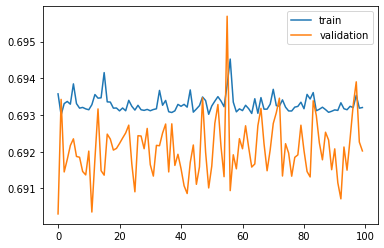

In [16]:
#Generamos plot con los resultados
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

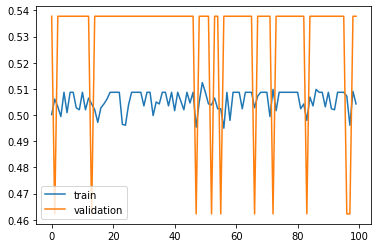

In [17]:
#Generamos plot con los resultados
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [18]:
# evaluate the model
#loss = model.evaluate(test_X, test_y, verbose=0)
#print('Test Loss: %.5f' % loss)

## Resultados con valores de test

In [19]:
# make a prediction
yhat = model.predict(test_X)

In [20]:
inv_y, inv_yhat = full_prediction(yhat, test_X, test_y)

In [21]:
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_y = scaler.inverse_transform(inv_y)


inv_yhat_df = pd.DataFrame(data=inv_yhat, columns=cols)
inv_y_df = pd.DataFrame(data=inv_y, columns=cols)

In [22]:
res = result(inv_yhat, inv_y)



res['Diff'] = np.where(res['Up_Down_yhat'] == res['Up_Down_y'] , 'Acierto', 'Error')

res['Diff'].value_counts()

print(res['Diff'].value_counts())
print()
per = res['Diff'].value_counts()['Acierto']/(res['Diff'].value_counts()['Acierto']+res['Diff'].value_counts()['Error'])
print(f'% acierto: {per}')

Error      341
Acierto    334
Name: Diff, dtype: int64

% acierto: 0.4948148148148148
